In [10]:
import torch
torch.cuda.is_available()

True

In [11]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
import e3nn
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [12]:
import warnings

warnings.filterwarnings("ignore", "The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`.")

# User Guide

In [152]:
irreps_input = o3.Irreps('10x0e + 10x1e')
irreps_output = o3.Irreps('20x0e + 10x1e')

In [153]:
# create node positions
num_nodes = 8
pos = torch.randn(num_nodes, 3)  # random node positions

# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)

print(edge_src.shape)

edge_vec = pos[edge_dst] - pos[edge_src]

# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([32])


4.0

In [154]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=pos[..., 0],
    y=pos[..., 1],
    z=pos[..., 2],
    mode='markers',
    marker=dict(
        size=1,
    )
))

for src, dst in zip(edge_src, edge_dst):
    fig.add_trace(go.Scatter3d(
        x=[pos[src][0], pos[dst][0]],
        y=[pos[src][1], pos[dst][1]],
        z=[pos[src][2], pos[dst][2]],
        mode='lines',
    ))

fig.show()

In [155]:
f_in = irreps_input.randn(num_nodes, -1)
print(f_in.pow(2).mean())
print(f_in.shape)

tensor(1.0538)
torch.Size([8, 40])


In [156]:
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)
print(irreps_sh)

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
# normalize=True ensure that x is divided by |x| before computing the sh

print(sh.pow(2).mean())  # should be close to 1
print(sh.shape)

1x0e+1x1o+1x2e
tensor(1.)
torch.Size([32, 9])


FullyConnectedTensorProduct(10x0e+10x1e x 1x0e+1x1o+1x2e -> 20x0e+10x1e | 400 paths | 400 weights) needs 400 weights


(<Figure size 640x480 with 1 Axes>, <Axes: >)

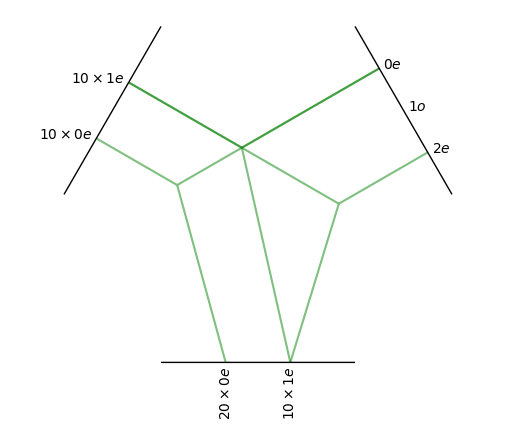

In [157]:
tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

print(f"{tp} needs {tp.weight_numel} weights")

tp.visualize()

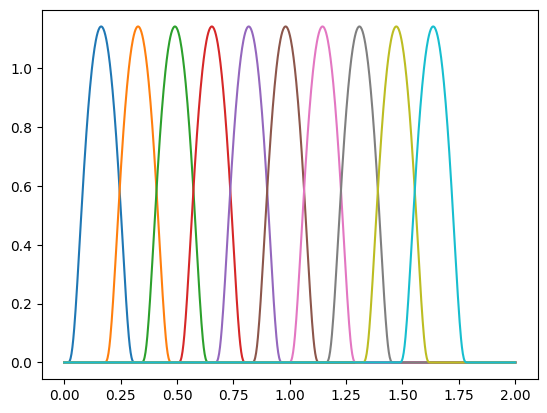

In [158]:
num_basis = 10

x = torch.linspace(0.0, 2.0, 1000)
y = soft_one_hot_linspace(
    x,
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)

plt.plot(x, y)
plt.show()

In [159]:
edge_length_embedding = soft_one_hot_linspace(
    edge_vec.norm(dim=1),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)
edge_length_embedding = edge_length_embedding.mul(num_basis**0.5)

print(edge_length_embedding.shape)
edge_length_embedding.pow(2).mean()  # the second moment

torch.Size([32, 10])


tensor(0.7169)

In [160]:
fc = nn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)
weight = fc(edge_length_embedding)

print(weight.shape)
print(len(edge_src), tp.weight_numel)

# For a proper normalization, the weights also need to be mean 0
print(weight.mean(), weight.std())  # should close to 0 and 1

torch.Size([32, 400])
32 400
tensor(0.0181, grad_fn=<MeanBackward0>) tensor(0.9364, grad_fn=<StdBackward0>)


In [161]:
summand = tp(f_in[edge_src], sh, weight)

print(summand.shape)
print(summand.pow(2).mean())  # should be close to 1

torch.Size([32, 50])
tensor(0.9260, grad_fn=<MeanBackward0>)


In [162]:
f_out = scatter(summand, edge_dst, dim=0, dim_size=num_nodes)

f_out = f_out.div(num_neighbors**0.5)

f_out.pow(2).mean()  # should be close to 1

tensor(0.9140, grad_fn=<MeanBackward0>)

In [163]:
def conv(f_in, pos):
    edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=len(pos) - 1)
    edge_vec = pos[edge_dst] - pos[edge_src]
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, max_radius, num_basis, basis='smooth_finite', cutoff=True).mul(num_basis**0.5)
    return scatter(tp(f_in[edge_src], sh, fc(emb)), edge_dst, dim=0, dim_size=num_nodes).div(num_neighbors**0.5)

In [164]:
rot = o3.rand_matrix()
D_in = irreps_input.D_from_matrix(rot)
D_out = irreps_output.D_from_matrix(rot)

# rotate before
f_before = conv(f_in @ D_in.T, pos @ rot.T)

# rotate after
f_after = conv(f_in, pos) @ D_out.T

torch.allclose(f_before, f_after, rtol=1e-4, atol=1e-4)

True

In [165]:
fig = go.Figure()

x = pos[..., 0]
y = pos[..., 1]
z = pos[..., 2]
values = f_in.norm(dim=0)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=values,
        colorscale='Viridis'
    ),
    showlegend=False,
))

for src, dst in zip(edge_src, edge_dst):
    fig.add_trace(go.Scatter3d(
        x=[pos[src][0], pos[dst][0]],
        y=[pos[src][1], pos[dst][1]],
        z=[pos[src][2], pos[dst][2]],
        mode='lines',
        line=dict(
            color='rgba(160,160,64,0.3)'
        ),
        showlegend=False,
    ))

fig.show()

In [166]:
fig = go.Figure()

new_pos = pos @ rot.T

x = new_pos[..., 0]
y = new_pos[..., 1]
z = new_pos[..., 2]
values = f_in.norm(dim=0)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=values,
        colorscale='Viridis'
    ),
    showlegend=False,
))

for src, dst in zip(edge_src, edge_dst):
    fig.add_trace(go.Scatter3d(
        x=[new_pos[src][0], new_pos[dst][0]],
        y=[new_pos[src][1], new_pos[dst][1]],
        z=[new_pos[src][2], new_pos[dst][2]],
        mode='lines',
        line=dict(
            color='rgba(160,160,64,0.3)'
        ),
        showlegend=False,
    ))

fig.show()

In [167]:
fig = go.Figure()

x = pos[..., 0]
y = pos[..., 1]
z = pos[..., 2]
values = f_in.norm(dim=0)

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=values,
        colorscale='Viridis'
    ),
    showlegend=False,
))

for src, dst in zip(edge_src, edge_dst):
    fig.add_trace(go.Scatter3d(
        x=[pos[src][0], pos[dst][0]],
        y=[pos[src][1], pos[dst][1]],
        z=[pos[src][2], pos[dst][2]],
        mode='lines',
        line=dict(
            color='rgba(32,255,32,0.3)',
            width=20,
        ),
        showlegend=False,
    ))

new_pos = pos @ rot.T

x = new_pos[..., 0]
y = new_pos[..., 1]
z = new_pos[..., 2]

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        # color=values,
        colorscale='Viridis'
    ),
    showlegend=False,
))

for src, dst in zip(edge_src, edge_dst):
    fig.add_trace(go.Scatter3d(
        x=[new_pos[src][0], new_pos[dst][0]],
        y=[new_pos[src][1], new_pos[dst][1]],
        z=[new_pos[src][2], new_pos[dst][2]],
        mode='lines',
        line=dict(
            color='rgba(80,40,212,0.3)',
            width=20,
        ),
        showlegend=False,
    ))

fig.show()

# API Docs

In [207]:
rot = o3.rand_matrix()
irreps_sh = o3.Irreps.spherical_harmonics(3)
D_sh = irreps_sh.D_from_matrix(rot)

In [210]:
x = torch.randn(100, 3)
y = x @ rot.T
x_sh = o3.spherical_harmonics(irreps_sh, x, True)
y_sh = o3.spherical_harmonics(irreps_sh, y, True)

print(y_sh[0])
print((x_sh @ D_sh.T)[0])
torch.allclose(x_sh @ D_sh.T, y_sh, rtol=1e-4, atol=1e-4)

tensor([ 0.2821, -0.3160,  0.3640,  0.0800, -0.1156, -0.5264,  0.2096,  0.1332,
        -0.2139,  0.1290, -0.2279, -0.5245, -0.0627,  0.1327, -0.4216, -0.1186])
tensor([ 0.2821, -0.3160,  0.3640,  0.0800, -0.1156, -0.5264,  0.2096,  0.1332,
        -0.2139,  0.1290, -0.2279, -0.5245, -0.0627,  0.1327, -0.4216, -0.1186])


True

# NN Models

In [13]:
from e3nn.nn.models.v2103.gate_points_networks import SimpleNetwork

irreps_in = o3.Irreps('3x0e + 2x1o')
irreps_out = o3.Irreps('1x1o')

net = SimpleNetwork(
    irreps_in=irreps_in,
    irreps_out=irreps_out,
    max_radius=2.0,
    num_neighbors=3.0,
    num_nodes=5.0,
)

pos = torch.randn(5, 3)
x = irreps_in.randn(5, -1)

net({
    'pos' : pos,
    'x' : x,
})

tensor([[2.9623, 0.8792, 2.0665]], grad_fn=<DivBackward0>)

In [14]:
rot = o3.matrix_x(torch.tensor(torch.pi / 3.0))
rot

tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.5000, -0.8660],
        [ 0.0000,  0.8660,  0.5000]])

In [15]:
rot_then_net = net({
    'pos' : pos @ rot.T,
    'x' : x @ irreps_in.D_from_matrix(rot).T,
})

In [16]:
net_then_rot = net({
    'pos' : pos,
    'x' : x,
}) @ irreps_out.D_from_matrix(rot).T

In [17]:
torch.allclose(rot_then_net, net_then_rot, rtol=1e-4, atol=1e-4)

True

In [18]:
from e3nn.nn.models.v2103.gate_points_networks import NetworkForAGraphWithAttributes

max_radius = 3.0

net = NetworkForAGraphWithAttributes(
    irreps_node_input="0e+1e",
    irreps_node_attr="0e+1e",
    irreps_edge_attr="0e+1e",  # attributes in extra of the spherical harmonics
    irreps_node_output="0e+1e",
    max_radius=max_radius,
    num_neighbors=4.0,
    num_nodes=5.0,
)

num_nodes = 5
pos = torch.randn(num_nodes, 4)
edge_index = radius_graph(pos, max_radius)
num_edges = edge_index.shape[1]

output = net({
    'pos': pos,
    'edge_index': edge_index,
    'node_input': torch.randn(num_nodes, 4),
    'node_attr': torch.randn(num_nodes, 4),
    'edge_attr': torch.randn(num_edges, 4),
})

In [19]:
output

tensor([[ 0.0493, -1.0103, -0.9709, -2.8745]], grad_fn=<DivBackward0>)